## Joint pertubation of features and the apex edge-sampled domains

# Imports

In [1]:
import os

# Enable CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Proceed with your code

from src.loader import load_graph
from classes import extract_all_features_single 
import sys
print(sys.executable)
import os
from src import utils
import numpy as np
import pandas as pd
import torch
import torch_geometric.transforms as T
from src.utils import largest_indices
from src.utils import cal_n_add_facni 
from src.utils import extract_feat_adj2
from src.utils import calc_cad 
import networkx as nx
from scipy import spatial
import copy  
from matplotlib import pyplot as plt 
import random

/home/sucharitha/MintA/venv_minta/bin/python


# Routines

In [2]:
def confid_measures(arr_tri, Num):
    arr_tri_mean=np.mean(arr_tri,axis=0)
    std=np.std(arr_tri,axis=0)
    Z=1.960 # for 95 conf.
    upper=arr_tri_mean+Z*std/np.sqrt(Num)
    lower=arr_tri_mean-Z*std/np.sqrt(Num)
    return np.sort(arr_tri_mean), np.sort(lower), np.sort(upper)

def find_my_soln(WW):
    ATA=np.dot(WW,WW.T)
    w, v=np.linalg.eig(ATA)
    return v[:,0]

def flip_the_bins(x,lox):
    m=np.zeros_like(x)
    m[:,lox]=1
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def preds_of_adv(model0, data, adv_nodes_test):
    with torch.no_grad():
        model0.eval()
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat= pred_raw0.argmax(dim=-1)
    preds=y0_hat[adv_nodes_test]
    return preds

def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy

def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat= pred_raw2.argmax(dim=-1)
    labels_sur=y2_hat[idx_train]    
    return labels_sur

def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

def do_perturb_feat(x,m):
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def do_perturb_adj(a,m):
    a_bol=np.array(a, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    a2=np.logical_xor(a_bol,m_bol)
    a2=a2.astype(float)
    a2=torch.from_numpy(a2)
    return a2

def A_to_edge_index(A):
    
    adj_t = torch.tensor(A) 
    edge_index = adj_t.nonzero().t().contiguous()
    return edge_index

def assign_Adversary_nas_mal(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)   
    return adv_nodes_test

def get_As_new(adj_1, adj_2, adj_3, adj_4, adv_nodes):
    
    edge_list= np.concatenate(( adj_2.cpu(), adj_4.cpu()), axis=1)
   
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

    A_adv=np.zeros( (len(adv_nodes),len(adv_nodes)), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv[lox_a,lox_b]=1 
    print("resssss", np.count_nonzero(A_adv))
   
    return A_adv

def edge_list_to_adj(adv_edge_list):
    elist=adv_edge_list.cpu()
    domain_node_list=np.unique(elist[0,:])
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=elist[k][0]
        b=elist[k][1]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_A(data, adv_nodes):
    edge_list_1=data.edge_index_dict['domain_node', 'apex', 'domain_node'][0,:]
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    common_node_lox=np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list=edge_list[:,common_node_lox]
    A_adv=edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist=adv_edge_lox2
    print(elist)
    domain_node_list=np.unique(elist)
    domain_node_list=domain_node_list[0:4000]
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=adv_edge_lox1[k]
        b=adv_edge_lox2[k]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_As_jan(data, adv_nodes):
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

#     adv_edge_list=edge_list[:,adv_edge_lox]
    L=len(adv_nodes)
    A_adv1=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv1[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv1))    
    
    
    edge_list=data.edge_index_dict['domain_node', 'similar', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

#     adv_edge_list=edge_list[:,adv_edge_lox]
    L=len(adv_nodes)
    A_adv2=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv2[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv2)) 
    
    
    A_adv=A_adv1+A_adv2
    
    return A_adv


# Debugging ASR calculation
def calc_ASR(data, adv_nodes_test, model):
    model.eval()
    pred_before = model(data.x_dict2, data.edge_index_dict2).argmax(dim=-1)
    pred_after = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    # Calculate ASR metrics
    num_of_1 = (pred_before[adv_nodes_test] == 1).sum().item()
    num_of_1_forced_to_0 = ((pred_before[adv_nodes_test] == 1) & (pred_after[adv_nodes_test] == 0)).sum().item()
    num_of_0 = (pred_before[adv_nodes_test] == 0).sum().item()
    num_of_0_forced_to_1 = ((pred_before[adv_nodes_test] == 0) & (pred_after[adv_nodes_test] == 1)).sum().item()

    ASRgood = num_of_1_forced_to_0 / max(num_of_1, 1)  # Avoid division by zero
    ASRbad = num_of_0_forced_to_1 / max(num_of_0, 1)  # Avoid division by zero

    # Debug logs
    print(f"Predictions before perturbation: {pred_before[adv_nodes_test]}")
    print(f"Predictions after perturbation: {pred_after[adv_nodes_test]}")
    print(f"ASRgood: {ASRgood}, ASRbad: {ASRbad}")

    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0

def assign_Adversary_ras(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)
#     adv_nodes_test=lox_test_space[0:norm_zero_int]
    return adv_nodes_test

# Load datasets

In [3]:
import warnings
warnings.filterwarnings('ignore')
from src.loader2 import DNS2
kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'
dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
data = dataset[0]
# dir(data)
# feats_2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_2, 'feats_2.pt')
# This script is for eature extraction
# import warnings
# warnings.filterwarnings('ignore')
# dir(data)
# feats_new2=cal_n_add_facni(kg_path('DNS_eid_adv'), data);
# torch.save(feats_new2, 'feats_new2.pt')

# Feature assignment 
feats_new2=torch.load('feats_new2.pt')
data['domain_node'].x= feats_new2[0:data.x_dict['domain_node'].shape[0],:]
data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
del feats_new2
# print(data.metadata)

# The MDD model 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, Linear

class GraphTransformerNetwork(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, num_heads=4, dropout=0.1):
        super().__init__()

        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = TransformerConv(
                in_channels=(-1, -1),  # Automatically infer input feature dimensions
                out_channels=hidden_channels,
                heads=num_heads,
                dropout=dropout,
                edge_dim=None  # Remove this if edge features are not used
            )
            self.convs.append(conv)

        # Final linear layer for output prediction
        self.lin = Linear(hidden_channels * num_heads, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # Convert heterogeneous inputs to a homogeneous format
        x = x_dict['domain_node']  # Assuming `domain_node` contains the node features
        edge_index = edge_index_dict[('domain_node', 'apex', 'domain_node')]  # Use the correct edge type

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # Pass through the final linear layer
        return self.lin(x)


# Initialize the GTN model
model = GraphTransformerNetwork(
    metadata=data.metadata(),  # Metadata for heterogeneous graph
    hidden_channels=64,        # Hidden feature size
    out_channels=2,            # Number of output classes (binary classification)
    num_layers=2               # Number of transformer layers
)


In [5]:
print(torch.cuda.device_count())  # Check for available CUDA devices

# Set CUDA device and move data and model to the GPU
torch.cuda.set_device(0)  # Use the first GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

# Initialize lazy modules by running a forward pass
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

# Define optimizer with Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

# Training function
def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)  # Forward pass
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])  # Cross-entropy loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    return float(loss)

# Testing function
@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)  # Predicted classes
    accs = []  # Store accuracy for train, validation, and test
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['domain_node'][split]
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()  # Accuracy
        accs.append(float(acc))
    return accs


1


# Surrogate model

In [6]:
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import dense_to_sparse  # To convert dense adjacency matrix to edge index
import torch.nn.functional as F
import numpy as np
import torch

# Extract data to train the surrogate model
train_mask = data['domain_node'].train_mask
labels_train = data['domain_node'].y.cpu()
labelled_labels_train_lox = np.where(labels_train < 2)  # Filter for binary classification labels
lox_train = np.where(train_mask.cpu() > 0)[0]  # Indices of training nodes

# Select training nodes and their features
adv_nodes_train = labelled_labels_train_lox[0][:4000]  # First 4000 nodes for training
Adj_sur = extract_As_jan(data, adv_nodes_train)  # Adjacency matrix for surrogate
features_sur = data['domain_node'].x[adv_nodes_train]  # Features of selected nodes

# Ensure features_sur is a PyTorch tensor
features_sur = torch.as_tensor(features_sur, dtype=torch.float32)

# Ensure Adj_sur is a PyTorch tensor
Adj_sur = torch.as_tensor(Adj_sur, dtype=torch.float32)

# Convert dense adjacency matrix (Adj_sur) to edge index format
edge_index_sur, _ = dense_to_sparse(Adj_sur)
edge_index_sur = edge_index_sur.to(torch.int64)  # Ensure integer type for edge index

# Prepare data for the surrogate model
x_sur = features_sur.to(device)  # Move features to the correct device
edge_index_sur = edge_index_sur.to(device)  # Move edge index to the correct device

# Define the Graph Transformer Network for surrogate model
class SurrogateGTN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers=2, num_heads=4, dropout=0.1):
        super(SurrogateGTN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                TransformerConv(
                    in_channels=(-1, -1),  # Automatically infer input features
                    out_channels=hidden_features,
                    heads=num_heads,
                    dropout=dropout
                )
            )
        self.fc = torch.nn.Linear(hidden_features * num_heads, out_features)

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)  # TransformerConv forward pass
            x = F.relu(x)  # Apply activation
        return self.fc(x)  # Final linear layer for classification

# Initialize the surrogate model
surrogate_model = SurrogateGTN(
    in_features=features_sur.shape[1],  # Input feature size
    hidden_features=64,  # Hidden layer size
    out_features=2,  # Binary classification
    num_layers=3,  # Increased number of transformer layers
    num_heads=4,
    dropout=0.15  # Increased dropout for better generalization
).to(device)

# Print shapes for debugging
print(f"Features shape: {x_sur.shape}")
print(f"Edge index shape: {edge_index_sur.shape}")

# Training loop
optimizer_surrogate = torch.optim.AdamW(surrogate_model.parameters(), lr=0.003, weight_decay=0.005)  # AdamW optimizer for better weight decay
loss_fn = torch.nn.CrossEntropyLoss()

labels_sur = data['domain_node'].y[adv_nodes_train].to(device)

# Validation function
@torch.no_grad()
def validate(model, x, edge_index, labels):
    model.eval()
    preds = model(x, edge_index).argmax(dim=-1)  # Predicted labels
    accuracy = (preds == labels).sum().item() / labels.size(0)  # Compute accuracy
    return accuracy

# Train surrogate model
best_val_acc = 0.0  # Track best validation accuracy
surrogate_model.train()
for epoch in range(50):
    optimizer_surrogate.zero_grad()
    out_surrogate = surrogate_model(x_sur, edge_index_sur)  # Shape: [4000, 2]
    loss = loss_fn(out_surrogate, labels_sur)
    loss.backward()
    optimizer_surrogate.step()

    if epoch % 10 == 0 or epoch == 49:
        val_acc = validate(surrogate_model, x_sur, edge_index_sur, labels_sur)
        best_val_acc = max(best_val_acc, val_acc)
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

print("Surrogate model training complete.")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

# Final evaluation
accuracy = validate(surrogate_model, x_sur, edge_index_sur, labels_sur)
print(f"Surrogate Model Final Accuracy: {accuracy * 100:.2f}%")


sparsity 3802
sparsity 2322
Features shape: torch.Size([4000, 45])
Edge index shape: torch.Size([2, 6123])
Epoch 0, Loss: 0.6484, Validation Accuracy: 83.40%
Epoch 10, Loss: 0.3902, Validation Accuracy: 83.40%
Epoch 20, Loss: 0.3930, Validation Accuracy: 83.40%
Epoch 30, Loss: 0.3826, Validation Accuracy: 83.40%
Epoch 40, Loss: 0.3801, Validation Accuracy: 83.40%
Epoch 49, Loss: 0.3774, Validation Accuracy: 83.40%
Surrogate model training complete.
Best Validation Accuracy: 83.40%
Surrogate Model Final Accuracy: 83.40%


# The proposed MinstA

In [7]:
def feat_perturb(x, A_adv, surrogate, val, adv_nodes_test, preds):
    x2 = x.clone()  # Clone the original feature tensor
    X = x[adv_nodes_test, :].cpu().numpy()  # Extract adversarial node features
    A = A_adv  # Adjacency matrix for perturbation
    X2 = X.copy()  # Clone the features for perturbation
    messages = np.dot(A, X2)  # Aggregate messages from neighbors

    perturbation_scale = val / 100  # Dynamic scaling of perturbation strength

    # Iterate over adversarial nodes to apply feature perturbation
    for i in range(min(val, len(adv_nodes_test))):  # Ensure `val` does not exceed node count
        if preds[i] > 0:  # Only perturb malicious nodes
            neighbors = np.flatnonzero(A[i, :])  # Find neighbors of the node
            if len(neighbors) == 0:
                continue  # Skip nodes with no neighbors

            # Compute perturbation based on neighbor features
            F1 = np.zeros_like(X[i])  # Initialize perturbation vector
            for neighbor in neighbors:
                message_j = messages[neighbor, :]  # Aggregate features from the neighbor
                F1 += message_j / len(neighbors)  # Average contribution from neighbors

            # Scale perturbation dynamically
            X2[i, :] += F1 * perturbation_scale

    # Update the original feature tensor with the perturbed features
    x2[adv_nodes_test, :] = torch.from_numpy(X2).to(x.device)

    # Debugging: Log L2 norm changes
    print(f"Initial L2 norm of features: {np.linalg.norm(X)}")
    print(f"Perturbed L2 norm of features: {np.linalg.norm(X2)}")
    print(f"Feature perturbation difference (L2 norm): {np.linalg.norm(X2 - X)}")

    return x2


In [8]:
def Adj_perturb_sim_apex(temp0, x, A_adv, surrogate, val, adv_nodes_test, preds):
    temp0 = np.array(temp0.cpu())
    X = x[adv_nodes_test, :].cpu().numpy()  # Extract adversarial node features
    A = A_adv  # Adjacency matrix
    X2 = X.copy()  # Clone the features for perturbation
    simi_arr = np.zeros([len(adv_nodes_test), len(adv_nodes_test)])  # Dynamic similarity matrix
    messages = np.dot(A, X2)  # Aggregate neighbor messages using adjacency

    perturb_edges = min(int(val * len(temp0[0]) / 100), simi_arr.size)  # Scale edges to perturb
    perturb_edges = max(1, perturb_edges)  # Ensure at least 1 edge is perturbed

    print(f"Perturbing {perturb_edges} edges...")

    for i in range(len(adv_nodes_test)):
        neighbors = np.flatnonzero(A[i, :])  # Find neighbors for node i
        if len(neighbors) == 0:
            print(f"Node {i} has no neighbors, skipping adjacency perturbation.")
            continue

        for j in range(len(adv_nodes_test)):
            F2 = np.zeros_like(X2[i])  # Initialize feature vector for similarity scoring
            for neighbor in neighbors:
                message_j = messages[neighbor, :]  # Aggregate neighbor features
                F2 += message_j / len(neighbors)  # Average neighbor contributions

            simi_arr[i, j] = np.linalg.norm(X2[i] + F2)  # Compute similarity score

    # Ensure the number of edges to perturb is valid
    if simi_arr.size < perturb_edges:
        print("Warning: Not enough similarity scores to perturb. Skipping adjacency perturbation.")
        return torch.tensor(temp0, dtype=torch.int64).to(x.device)

    # Find indices of the largest similarity scores
    largest_idx = largest_indices(simi_arr, perturb_edges)
    largest_idx = np.array(largest_idx)

    # Create a binary matrix to indicate edges to be perturbed
    m = np.zeros([len(adv_nodes_test), len(adv_nodes_test)])
    for i in range(largest_idx.shape[1]):
        m[largest_idx[0, i], largest_idx[1, i]] = 1

    # Apply adjacency perturbation
    A2 = do_perturb_adj(A, m)
    aa = A_to_edge_index(A2)

    # Map adversarial nodes to the perturbed edges
    conv = np.zeros_like(aa)
    for k in range(aa.shape[1]):
        conv[0, k] = adv_nodes_test[aa[0, k]]
        conv[1, k] = adv_nodes_test[aa[1, k]]

    # Combine original edges with perturbed edges
    all_edges = temp0
    adv_edge_lox = np.nonzero(np.in1d(all_edges[0, :], adv_nodes_test))[0]  # Find adversarial edges
    non_adv_edges = np.delete(all_edges, adv_edge_lox, axis=1)  # Remove adversarial edges
    temp2 = np.hstack((non_adv_edges, conv))  # Combine non-adversarial and perturbed edges
    temp2 = torch.tensor(temp2, dtype=torch.int64).to(x.device)  # Convert to tensor and ensure device compatibility

    return temp2


In [9]:
def one_trial():
    # Initialize and load dataset
    dataset = DNS2(
        'myGraph_datasets/DNS',
        transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]),
        balance_gt=True
    )
    data = dataset[0]

    # Load precomputed node features
    feats_new = torch.load('feats_new2.pt')
    data['domain_node'].x = feats_new[:data.x_dict['domain_node'].shape[0], :]
    data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1)
    data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1)
    del feats_new

    # Initialize adversarial nodes and adjacency
    x = data['domain_node'].x.cpu()
    adv_nodes_test = assign_Adversary_ras(data, 100)
    A_adv = extract_As_jan(data, adv_nodes_test)

    # Initialize performance tracking
    perf_arr = np.empty((6, 0))
    val_nodes = np.array([1, 5, 20, 40, 60, 80, 100])

    # Initialize and train the main GTN-based HeteroGNN
    model0 = GraphTransformerNetwork(
        metadata=data.metadata(),
        hidden_channels=64,
        out_channels=2,
        num_layers=3,  # Increased number of layers for better feature representation
        num_heads=4,
        dropout=0.15
    ).to(device)

    data = data.to(device)

    # Backup original data
    data.x_dict2 = copy.deepcopy(data.x_dict)
    data.edge_index_dict2 = copy.deepcopy(data.edge_index_dict)

    # Train the GTN-based HeteroGNN
    print("Training main GTN model...")
    for epoch in range(201):
        loss = train(model0, data)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    # Define idx_train for training nodes
    idx_train = np.where(data['domain_node'].train_mask.cpu().numpy())[0]  # Indices of training nodes

    # Generate labels using the trained model
    labels_sur = model_qurey(model0, data, idx_train)
    labels_sur = np.array(labels_sur.cpu())
    preds = preds_of_adv(model0, data, adv_nodes_test)

    # Initialize and train the surrogate GTN
    surrogate = SurrogateGTN(
        in_features=data['domain_node'].x.shape[1],
        hidden_features=64,
        out_features=2,
        num_layers=3,  # Match the main GTN's complexity
        num_heads=4,
        dropout=0.15
    ).to(device)

    optimizer_surrogate = torch.optim.Adam(surrogate.parameters(), lr=0.005, weight_decay=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # Prepare inputs for the surrogate model
    features_sur = data['domain_node'].x[adv_nodes_test].to(device)
    edge_index_sur = dense_to_sparse(torch.tensor(A_adv, dtype=torch.float32).to(device))[0]
    labels_sur_cpu = torch.tensor(labels_sur[:features_sur.shape[0]], dtype=torch.long).to(device)

    # Train the surrogate GTN
    print("Training surrogate GTN model...")
    surrogate.train()
    for epoch in range(50):
        optimizer_surrogate.zero_grad()
        out_surrogate = surrogate(features_sur, edge_index_sur)
        loss = loss_fn(out_surrogate, labels_sur_cpu)
        loss.backward()
        optimizer_surrogate.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    print("Surrogate model training complete.")

    # Perturbation and ASR calculation
    print("Starting perturbation and ASR calculation...")
    for val in val_nodes:
        print(f"Processing perturbation with val={val}")

        # Feature perturbation
        x = data['domain_node'].x.cpu()
        x2 = feat_perturb(x, A_adv, surrogate, val, adv_nodes_test, preds)
        x2 = x2.to(device)
        data.x_dict2['domain_node'] = x2

        # Adjacency perturbation
        temp0_sim = data.edge_index_dict2[('domain_node', 'apex', 'domain_node')]
        temp2_sim = Adj_perturb_sim_apex(temp0_sim, x, A_adv, surrogate, val, adv_nodes_test, preds)
        temp2_sim = temp2_sim.to(device)
        data.edge_index_dict2[('domain_node', 'apex', 'domain_node')] = temp2_sim
        data = data.to(device)

        # Calculate ASR
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0 = calc_ASR(data, adv_nodes_test, model0)
        print(f"val={val}, ASRgood={ASRgood:.4f}, num_of_1_forced_to_0={num_of_1_forced_to_0}, num_of_1={num_of_1}")
        print(f"val={val}, ASRbad={ASRbad:.4f}, num_of_0_forced_to_1={num_of_0_forced_to_1}, num_of_0={num_of_0}")
        
        # Track results
        temp_res = np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1, 1)
        perf_arr = np.hstack((perf_arr, temp_res))

    return perf_arr


In [13]:
Num=30
res_arr=np.zeros((Num, 6,7))
for tri in range(Num):
    print(tri)
    g1=one_trial()
    res_arr[tri,:,:]=g1

0
sparsity 84
sparsity 42
Training main GTN model...
Epoch 0, Loss: 0.7045
Epoch 50, Loss: 0.6996
Epoch 100, Loss: 0.7051
Epoch 150, Loss: 0.6933
Epoch 200, Loss: 0.7007
Training surrogate GTN model...
Epoch 0, Loss: 0.7471
Epoch 10, Loss: 0.5715
Epoch 20, Loss: 0.5350
Epoch 30, Loss: 0.4760
Epoch 40, Loss: 0.2899
Surrogate model training complete.
Starting perturbation and ASR calculation...
Processing perturbation with val=1
Initial L2 norm of features: 284.66473388671875
Perturbed L2 norm of features: 284.6978454589844
Feature perturbation difference (L2 norm): 0.3606356084346771
Perturbing 1789 edges...
Node 2 has no neighbors, skipping adjacency perturbation.
Node 6 has no neighbors, skipping adjacency perturbation.
Node 7 has no neighbors, skipping adjacency perturbation.
Node 10 has no neighbors, skipping adjacency perturbation.
Node 11 has no neighbors, skipping adjacency perturbation.
Node 24 has no neighbors, skipping adjacency perturbation.
Node 27 has no neighbors, skipping

In [14]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=arr1[:,2].mean()
avg_ben_num=arr1[:,5].mean()

# Plot results

In [15]:
val_nodes=np.array([1,5,20,40,60,80,100])

In [16]:
Num=30
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

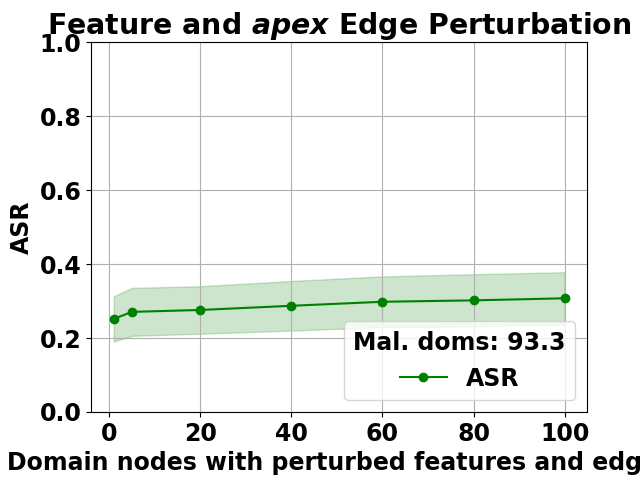

In [23]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_comb_2_sampled_doms'):
    os.makedirs('RESULTS_comb_2_sampled_doms')
plt.figure(facecolor='white')
plt.title("Feature and $\it{apex}$ Edge Perturbation")
plt.xlabel("Domain nodes with perturbed features and edges", weight='bold') 
plt.ylabel("ASR", weight='bold') 
# plot the ASR:
m0, l0, u0=confid_measures(res_arr[:,0,:], 100)
plt.plot(val_nodes, m0,'-og', label=("ASR"))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
plt.ylim(0, 1)
plt.grid()
legend_text = 'Mal. doms: %.1f' % (93.29)
plt.legend(loc='lower right', fontsize="11",prop=dict(weight='bold'),title=legend_text)
name='RESULTS_comb_2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_comb_2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot NFR

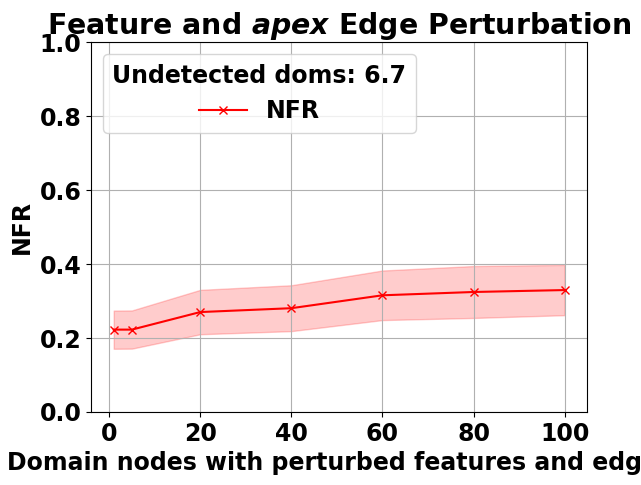

In [25]:
plt.figure(facecolor='white')
plt.title("Feature and $\it{apex}$ Edge Perturbation")
plt.xlabel("Domain nodes with perturbed features and edges", weight='bold') 
plt.ylabel("NFR", weight='bold') 
m3, l3, u3=confid_measures(res_arr[:,3,:], 100)
plt.plot(val_nodes, m3,'-xr', label=("NFR"))
plt.fill_between(num_change_arr, l3, u3, color='red', alpha=0.2)
plt.ylim(0, 1)
plt.grid()
legend_text = 'Undetected doms: %.1f' % (6.71)
plt.legend(loc='upper left', fontsize="11",prop=dict(weight='bold'),title=legend_text)
name='RESULTS_comb_2_sampled_doms/asr_plot3_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_comb_2_sampled_doms/asr_plot3_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()

## Plot ROC

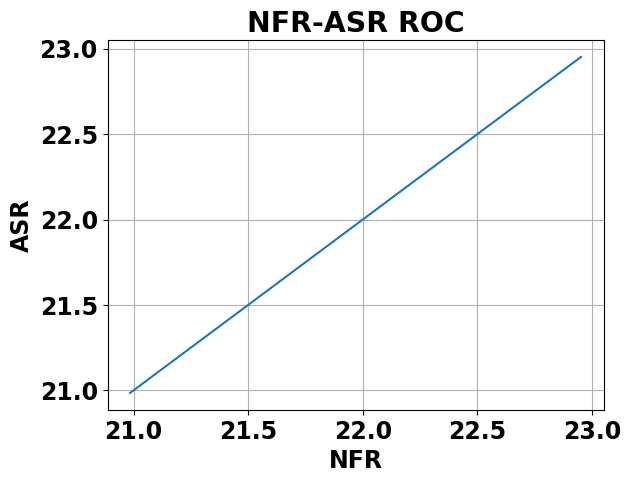

In [19]:
tpr=m0
fpr=m3
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC")

plt.xlabel("NFR", weight='bold') 
plt.ylabel("ASR", weight='bold') 
m3, l3, u3=confid_measures(arr1, 100)
plt.plot(fpr, tpr) 
plt.grid()
name='RESULTS_comb_2_sampled_doms/asr_plot3_'+ str(Num)+'_ROC.png'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
name='RESULTS_comb_2_sampled_doms/asr_plot3_'+ str(Num)+'_ROC.pdf'
plt.savefig(name, dpi=150, bbox_inches = 'tight') 
plt.show()